In [53]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

/Users/alejandrobreen/opt/anaconda3/lib/python3.9/site-packages/sklearn/datasets/_openml.py:968: FutureWarning:

The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.



In [54]:
import numpy as np
from gtda.plotting import plot_heatmap

im8_idx = np.flatnonzero(y == "8")[0]
img8 = X[im8_idx].reshape(28, 28)
plot_heatmap(img8)

In [55]:
from gtda.images import Binarizer

im8 = np.array([img8])
binarizer = Binarizer(threshold=0.4)
im8_binarized = binarizer.fit_transform(im8)

binarizer.plot(im8_binarized)

In [56]:
from gtda.images import RadialFiltration

radial_filtration = RadialFiltration(center=np.array([20, 6]))
im8_filtration = radial_filtration.fit_transform(im8_binarized)

radial_filtration.plot(im8_filtration, colorscale="jet")

In [57]:
from gtda.homology import CubicalPersistence

cubical_persistence = CubicalPersistence(n_jobs=-1)
im8_cubical = cubical_persistence.fit_transform(im8_filtration)

cubical_persistence.plot(im8_cubical)

In [63]:
from gtda.diagrams import Scaler

scaler = Scaler()
im8_scaled = scaler.fit_transform(im8_cubical)

scaler.plot(im8_scaled)

In [64]:
from gtda.diagrams import HeatKernel

heat = HeatKernel(sigma=.15, n_bins=60, n_jobs=-1)
im8_heat = heat.fit_transform(im8_scaled)

# Visualise the heat kernel for H1
heat.plot(im8_heat, homology_dimension_idx=1, colorscale='jet')
     

In [83]:
from sklearn.pipeline import Pipeline
from gtda.diagrams import Amplitude

steps = [
    ("binarizer", Binarizer(threshold=0.4)),
    ("filtration", RadialFiltration(center=np.array([20, 6]))),
    ("diagram", CubicalPersistence()),
    ("rescaling", Scaler()),
    ("amplitude", Amplitude(metric="heat", metric_params={'sigma':0.15, 'n_bins':60}))
]

heat_pipeline = Pipeline(steps)

In [84]:
im8_pipeline = heat_pipeline.fit_transform(im8)
im8_pipeline

array([[0.00457082, 2.49742581]])

In [69]:
from sklearn.pipeline import make_pipeline, make_union
from gtda.diagrams import PersistenceEntropy
from gtda.images import HeightFiltration

direction_list = [[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]]

center_list = [
    [13, 6],
    [6, 13],
    [13, 13],
    [20, 13],
    [13, 20],
    [6, 6],
    [6, 20],
    [20, 6],
    [20, 20],
]

# Creating a list of all filtration transformer, we will be applying
filtration_list = (
    [
        HeightFiltration(direction=np.array(direction), n_jobs=-1)
        for direction in direction_list
    ]
    + [RadialFiltration(center=np.array(center), n_jobs=-1) for center in center_list]
)

# Creating the diagram generation pipeline
diagram_steps = [
    [
        Binarizer(threshold=0.4, n_jobs=-1),
        filtration,
        CubicalPersistence(n_jobs=-1),
        Scaler(n_jobs=-1),
    ]
    for filtration in filtration_list
]

# Listing all metrics we want to use to extract diagram amplitudes
metric_list = [
    {"metric": "bottleneck", "metric_params": {}},
    {"metric": "wasserstein", "metric_params": {"p": 1}},
    {"metric": "wasserstein", "metric_params": {"p": 2}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 2, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 2, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 1, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 3.2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 3.2, "n_bins": 100}},
]

#
feature_union = make_union(
    *[PersistenceEntropy(nan_fill_value=-1)]
    + [Amplitude(**metric, n_jobs=-1) for metric in metric_list]
)

tda_union = make_union(
    *[make_pipeline(*diagram_step, feature_union) for diagram_step in diagram_steps],
    n_jobs=-1
)

In [70]:

from sklearn import set_config
set_config(display='diagram')  

tda_union

FeatureUnion(n_jobs=-1,
             transformer_list=[('pipeline-1',
                                Pipeline(steps=[('binarizer',
                                                 Binarizer(n_jobs=-1,
                                                           threshold=0.4)),
                                                ('heightfiltration',
                                                 HeightFiltration(direction=array([1, 0]),
                                                                  n_jobs=-1)),
                                                ('cubicalpersistence',
                                                 CubicalPersistence(n_jobs=-1)),
                                                ('scaler', Scaler(n_jobs=-1)),
                                                ('featureunion',
                                                 FeatureUnion(transformer_list=[('persistenceentropy',
                                                                                 Persist...
                                                                                           metric_params={'n_bins': 100,
                                                                                                          'p': 1,
                                                                                                          'sigma': 1.6},
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-11',
                                                                                 Amplitude(metric='heat',
                                                                                           metric_params={'n_bins': 100,
                                                                                                          'p': 1,
                                                                                                          'sigma': 3.2},
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-12',
                                                                                 Amplitude(metric='heat',
                                                                                           metric_params={'n_bins': 100,
                                                                                                          'p': 2,
                                                                                                          'sigma': 1.6},
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-13',
                                                                                 Amplitude(metric='heat',
                                                                                           metric_params={'n_bins': 100,
                                                                                                          'p': 2,
                                                                                                          'sigma': 3.2},
                                                                                           n_jobs=-1))]))]))])

In [71]:
X_train_tda = tda_union.fit_transform(X_train)
X_train_tda.shape

(60, 476)

In [72]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train_tda, y_train)

X_test_tda = tda_union.transform(X_test)
rf.score(X_test_tda, y_test)
     

0.7

# NOW USING NEW BINARIZER

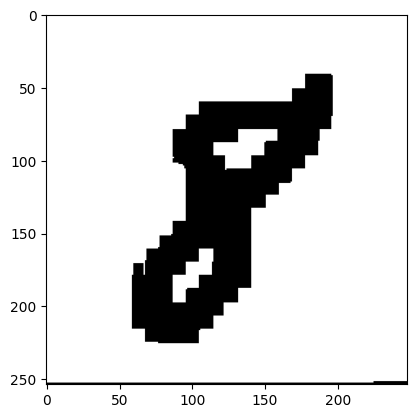

In [58]:
import fingerprint
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import invert
from gtda.homology import VietorisRipsPersistence
from gtda.images import RadialFiltration
from gtda.plotting import plot_diagram

# Binarizing finger print image
original_img = cv2.imread("images/q.png", cv2.IMREAD_ANYCOLOR)

BnW_image = fingerprint.BinarizeFingerprint(original_img, 
                                            method='Pixel Blocks Optimized', 
                                            blockSize=200)
#BnW_image = invert(BnW_image)

# Plotting
plt.imshow(BnW_image, cmap='gray')
plt.show()

In [59]:

#im_binarized = np.array([[[0, 0, 0], [1, 1, 0], [3, 2, 0], [2, 3, 0], [3, 3, 1], [2, 2, 2]]])
radial_filtration = RadialFiltration(center=np.array([150, 50]))
filtered = radial_filtration.fit_transform(np.array([invert(BnW_image)]))

radial_filtration.plot(filtered, colorscale="jet")

In [101]:
persistence = VietorisRipsPersistence(
    metric="euclidean",
    homology_dimensions=[0, 1], # Track connected components, loops
    n_jobs=6
)

diagrams_basic = persistence.fit_transform(filtered)


plot_diagram(diagrams_basic[0])

In [102]:
from gtda.diagrams import Scaler

scaler = Scaler()
scaled_diagrams = scaler.fit_transform(diagrams_basic)

scaler.plot(scaled_diagrams)

In [103]:
from gtda.diagrams import HeatKernel

heat = HeatKernel(sigma=.15, n_bins=60, n_jobs=-1)
heat_img = heat.fit_transform(scaled_diagrams)

# Visualise the heat kernel for H1
heat.plot(heat_img, homology_dimension_idx=1, colorscale='jet')
     

# Attempt at Pipeline

In [109]:
def heat_pipeline(img, center=[150, 50]):
    BnW_image = fingerprint.BinarizeFingerprint(original_img, 
                                            method='Pixel Blocks Optimized', 
                                            blockSize=200)
    
    radial_filtration = RadialFiltration(center=np.array(center))
    filtered = radial_filtration.fit_transform(np.array([invert(BnW_image)]))

    persistence = VietorisRipsPersistence(
        metric="euclidean",
        homology_dimensions=[0, 1], # Track connected components, loops
        n_jobs=6
    )

    diagrams_basic = persistence.fit_transform(filtered)

    scaler = Scaler()
    scaled_diagrams = scaler.fit_transform(diagrams_basic)

    # heat = HeatKernel(sigma=.15, n_bins=60, n_jobs=-1)
    # heat_img = heat.fit_transform(scaled_diagrams)
    return scaled_diagrams



In [110]:
original_img = cv2.imread("images/print1.png", cv2.IMREAD_ANYCOLOR)
scaled_diagrams = heat_pipeline(original_img)

h = HeatKernel(sigma=.15, n_bins=60, n_jobs=-1)
h_img = h.fit_transform(scaled_diagrams)
h.plot(h_img, homology_dimension_idx=1, colorscale='jet')